In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tf2cv tensorflow>=2.0.0

In [4]:
from tensorflow.python.client import device_lib
dev=device_lib.list_local_devices()
dev[len(dev)-1]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12290800378230770251
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [0]:
#global consts
IMG_SIZE='137x236'
HEIGHT = 137
WIDTH = 236
BATCH_SIZE=150
DROP_OUT=0.2
FOLD=0
TRAIN_DIR = './train/'
TRAIN_IMG_DIR=TRAIN_DIR+str(IMG_SIZE)
EPOCHS = 200
STATS_FS = (0.055029564364430086, 0.17228061284674265)
STATS_128 = (0.0692, 0.2051)
EXPERIMENT='distrib'
INPUT_DIR ='/content/drive/My Drive/kaggle/bengali/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/bengali/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/bengali/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
DATASET_224='224x224-bengali.zip'
DATASET_128='grapheme-imgs-128x128.zip'
DATASET_FS = 'bengali-full-size.zip'
TRAIN_WITH_FOLD = 'train_with_fold_20.csv'
PRETRAINED = True
PRETRAINED_WEIGHTS = 'w_pl_9768.h5'
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'
#INITIAL_EPOCH=40
#HEAD_WD=1e-3
#BACKBONE_WD = 1e-4

if IMG_SIZE == 128: DATASET=DATASET_128
if IMG_SIZE == 224: DATASET=DATASET_224
if IMG_SIZE == '137x236' : DATASET=DATASET_FS


#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import sys
sys.path.append(IMPORT_DIR+'py/models/')
sys.path.append(IMPORT_DIR+'py/utils/')
sys.path.append(IMPORT_DIR+'py/callbacks/')
sys.path.append(IMPORT_DIR+'py/opts/')

In [0]:
#import local modules
#from mish import Mish,mish
from generators import *
from kaggle_metric import *
#from cosine import CosineAnnealingScheduler
from kagglevalidation import KaggleValidationFS
#from lookahead import Lookahead
from se_resnext50 import build_se_resnext50_model_fs_wod
#from md121v2 import build_md121_v2_model
#from losses import categorical_focal_loss


#import external modules
import numpy as np 
import pandas as pd 

import os
import errno

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [9]:
try:
  os.mkdir(TRAIN_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_DIR+' already exists')
    else:
        raise
try:
  os.mkdir(TRAIN_IMG_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(TRAIN_IMG_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise


os.system('cp '+ '"'+INPUT_DIR+DATASET+'" ' + TRAIN_DIR)
os.system('cp '+ '"'+INPUT_DIR+TRAIN_WITH_FOLD+'" ' + TRAIN_DIR)


/content/drive/My Drive/kaggle/bengali/output/distrib/ already exists
/content/drive/My Drive/kaggle/bengali/output/distrib/chkp/ already exists


0

In [0]:
if PRETRAINED: os.system('cp '+ '"'+EXPERIMENT_DIR+PRETRAINED_WEIGHTS+'" '+TRAIN_DIR)

In [11]:
os.system('unzip -q '+TRAIN_DIR+DATASET+ ' -d '+ TRAIN_IMG_DIR)

0

In [21]:
!ls train

137x236  bengali-full-size.zip	train_with_fold_20.csv	w_pl_9768.h5


In [0]:
dataset_np = pd.read_csv(TRAIN_DIR+TRAIN_WITH_FOLD).to_numpy()
dataset_np[:,0]+='.png'
dataset_m = dataset_np.shape[0]


valid_m = np.where(dataset_np[:,6]==FOLD)[0].shape[0]
train_m = dataset_m-valid_m

fold_train_inds = np.where(dataset_np[:,6] != FOLD)
fold_valid_inds = np.where(dataset_np[:,6] == FOLD)

train_np = dataset_np[fold_train_inds]
valid_np = dataset_np[fold_valid_inds]

train_df = pd.DataFrame(train_np)
valid_df = pd.DataFrame(valid_np)

train_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)
valid_df.rename(columns={0:'filename',1:'root_class',2:'vowel_class',3:'cons_class', 4:'grapheme'}, inplace=True)

train_df.drop(columns=[5,6], inplace=True)
valid_df.drop(columns=[5,6], inplace=True)

In [14]:
dataset_np

array([['Train_0.png', 15, 9, ..., 'ক্ট্রো', 0, 17],
       ['Train_1.png', 159, 0, ..., 'হ', 1, 6],
       ['Train_2.png', 22, 3, ..., 'খ্রী', 2, 11],
       ...,
       ['Train_200837.png', 2, 1, ..., 'অ্যা', 200837, 16],
       ['Train_200838.png', 152, 9, ..., 'স্নো', 200838, 12],
       ['Train_200839.png', 127, 2, ..., 'ল্টি', 200839, 10]],
      dtype=object)

In [0]:
train_np

array([['Train_0.png', 15, 9, ..., 'ক্ট্রো', 0, 17],
       ['Train_1.png', 159, 0, ..., 'হ', 1, 6],
       ['Train_2.png', 22, 3, ..., 'খ্রী', 2, 11],
       ...,
       ['Train_200837.png', 2, 1, ..., 'অ্যা', 200837, 16],
       ['Train_200838.png', 152, 9, ..., 'স্নো', 200838, 12],
       ['Train_200839.png', 127, 2, ..., 'ল্টি', 200839, 10]],
      dtype=object)

In [0]:
triplets=np.array(dataset_np[:,1:4],dtype=int)

In [0]:
len(dataset_np)

200840

In [0]:
triplets_train = np.array(train_np[:,1:4],dtype=int)

In [0]:
(unique,counts)=np.unique(triplets, axis=0, return_counts=True)

In [0]:
(tr_unique,tr_counts)=np.unique(triplets_train, axis=0, return_counts=True)

In [0]:
data=np.c_[unique,counts]

In [0]:
data_tr=np.c_[tr_unique,tr_counts]

In [0]:
EXPERIMENT_DIR

'/content/drive/My Drive/kaggle/bengali/output/distrib/'

In [0]:
from numpy import savetxt
savetxt(EXPERIMENT_DIR+'data.csv', data, delimiter=',')

In [0]:
from numpy import savetxt
savetxt(EXPERIMENT_DIR+'data_tr.csv', data_tr, delimiter=',')

In [0]:
unique

array([[  0,   0,   0],
       [  1,   0,   0],
       [  2,   0,   0],
       ...,
       [167,   5,   0],
       [167,   7,   0],
       [167,   9,   0]])

In [0]:
model =  build_se_resnext50_model_fs_wod(height=HEIGHT, width=WIDTH)

In [20]:
TRAIN_DIR+PRETRAINED_WEIGHTS

'./train/w_pl_9768.h5'

In [18]:
import gc
gc.collect()

2614

In [0]:
  model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)
  train_gen = test_batch_generator_fs(train_df,TRAIN_IMG_DIR,batch_size=512,height=HEIGHT,width=WIDTH,st=STATS_FS)
  root_predicts,vowel_predicts,cons_predicts=get_p_dicts(model,train_gen)
  gc.collect()

27552

In [0]:
compute_recall(train_df,root_predicts,vowel_predicts,cons_predicts)

(0.9972682042287963, 0.9983816201783804, 0.9980586012519151)

In [0]:
  model.load_weights(TRAIN_DIR+PRETRAINED_WEIGHTS)
  valid_gen = test_batch_generator_fs(valid_df,TRAIN_IMG_DIR,batch_size=512,height=HEIGHT,width=WIDTH,st=STATS_FS)
  root_predicts,vowel_predicts,cons_predicts=get_p_dicts(model,valid_gen)
  gc.collect()

In [22]:
compute_recall(valid_df,root_predicts,vowel_predicts,cons_predicts)

(0.9799516655506983, 0.9947481656763973, 0.9919760128090347)

In [0]:
roots,vowels,conss=compute_cm(valid_df,root_predicts,vowel_predicts,cons_predicts)

In [24]:
vowels

array([0.99036145, 0.99076589, 0.99924755, 0.99878935, 0.99470899,
       1.        , 1.        , 0.99438202, 0.98809524, 0.98587933,
       1.        ])

In [25]:
conss

array([0.9936143 , 0.98941799, 0.99084097, 1.        , 0.9941349 ,
       0.99074931, 0.98507463])

In [26]:
roots

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.75      , 1.        , 0.9795082 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9375    , 1.        , 0.98026316, 0.97526502, 1.        ,
       0.98113208, 1.        , 1.        , 1.        , 0.95714286,
       1.        , 0.97222222, 0.95588235, 1.        , 1.        ,
       0.89473684, 1.        , 1.        , 0.99428571, 1.        ,
       1.        , 1.        , 0.98181818, 0.9798995 , 1.        ,
       1.        , 0.96551724, 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.96428571, 0.98125   , 1.        ,
       1.        , 0.99253731, 1.        , 0.98305085, 0.99122807,
       0.95833333, 0.91176471, 0.92682927, 1.        , 0.98113208,
       1.        , 1.        , 0.90909091, 1.        , 1.        ,
       0.98113208, 0.98101266, 0.99348534, 1.        , 1.     

In [85]:
threshold = 0.95
hard_classes=np.where(roots<threshold)[0]
light_classes=np.where(roots>=threshold)[0]
hard_recalls=roots[hard_classes]

for i in range(hard_classes.shape[0]):
  idx = hard_classes[i]
  print(f'{idx} {roots[idx]}')


11 0.75
20 0.9375
35 0.8947368421052632
61 0.9117647058823529
62 0.926829268292683
67 0.9090909090909091
82 0.9230769230769231
83 0.8787878787878788
84 0.9090909090909091
85 0.9130434782608695
87 0.9
91 0.948051948051948
95 0.9333333333333333
116 0.8823529411764706
120 0.9333333333333333
140 0.9454545454545454
141 0.9493670886075949
144 0.9310344827586207
146 0.9333333333333333
148 0.9431818181818182
166 0.9


In [0]:
def print_norm_and_errors(root):
  errors_root = [] 
  for k,x in enumerate(valid_np[:]):
    pred = np.argmax(root_predicts[k])
    pred_v = np.argmax(vowel_predicts[k])
    pred_c = np.argmax(cons_predicts[k])
    max_prob = np.max(root_predicts[k])
    true_prob = root_predicts[k][root]
    if x[1]==root and pred != root: 
      print(k,x,pred,pred_v,pred_c,max_prob,true_prob)
      errors_root.append(x[0])

  norm_root = [] 
  for k,x in enumerate(valid_np[:]):
    pred = np.argmax(root_predicts[k])
    pred_v = np.argmax(vowel_predicts[k])
    pred_c = np.argmax(cons_predicts[k])
    max_prob = np.max(root_predicts[k])
    true_prob = root_predicts[k][root]
    if x[1]==root and pred == root: 
      print(k,x,pred,pred_v,pred_c,max_prob,true_prob)
      norm_root.append(x[0])
    
  return errors_root,norm_root

In [66]:
info_11 = print_norm_and_errors(11)

1337 ['Train_26752.png' 11 0 0 'ও' 26752 0] 65 0 0 0.8629407 0.06495992
3836 ['Train_76750.png' 11 0 0 'ও' 76750 0] 65 0 0 0.68642926 0.19109431
482 ['Train_9647.png' 11 0 0 'ও' 9647 0] 11 0 0 0.96959037 0.96959037
843 ['Train_16902.png' 11 0 0 'ও' 16902 0] 11 0 0 0.99693656 0.99693656
4587 ['Train_91749.png' 11 0 0 'ও' 91749 0] 11 0 0 0.99783945 0.99783945
6705 ['Train_134105.png' 11 0 0 'ও' 134105 0] 11 0 0 0.39587176 0.39587176
6716 ['Train_134354.png' 11 0 0 'ও' 134354 0] 11 0 0 0.9718777 0.9718777
8810 ['Train_176216.png' 11 0 0 'ও' 176216 0] 11 0 0 0.99802965 0.99802965


In [48]:
info_65 = print_norm_and_errors(65)

352 ['Train_7062.png' 65 0 4 'ত্ত্য' 7062 0] 65 0.9981641 0.9981641
638 ['Train_12776.png' 65 9 0 'ত্তো' 12776 0] 65 0.9976829 0.9976829
746 ['Train_14931.png' 65 7 0 'ত্তে' 14931 0] 65 0.99874026 0.99874026
907 ['Train_18153.png' 65 0 4 'ত্ত্য' 18153 0] 65 0.99775594 0.99775594
1054 ['Train_21095.png' 65 7 0 'ত্তে' 21095 0] 65 0.9983352 0.9983352
1107 ['Train_22162.png' 65 9 0 'ত্তো' 22162 0] 65 0.9850167 0.9850167
1263 ['Train_25276.png' 65 3 0 'ত্তী' 25276 0] 65 0.99445975 0.99445975
1320 ['Train_26417.png' 65 0 0 'ত্ত' 26417 0] 65 0.9964972 0.9964972
1661 ['Train_33243.png' 65 9 0 'ত্তো' 33243 0] 65 0.98766124 0.98766124
1767 ['Train_35359.png' 65 3 2 'র্ত্তী' 35359 0] 65 0.9970282 0.9970282
1772 ['Train_35467.png' 65 3 0 'ত্তী' 35467 0] 65 0.9906069 0.9906069
1843 ['Train_36873.png' 65 3 2 'র্ত্তী' 36873 0] 65 0.9889713 0.9889713
1889 ['Train_37798.png' 65 2 0 'ত্তি' 37798 0] 65 0.7495521 0.7495521
1919 ['Train_38387.png' 65 2 0 'ত্তি' 38387 0] 65 0.98043114 0.98043114
1940 ['Trai

In [54]:
info_35 = print_norm_and_errors(35)

3348 ['Train_67003.png' 35 2 0 'ঙ্খি' 67003 0] 37 0.96471715 0.027833922
5118 ['Train_102369.png' 35 2 0 'ঙ্খি' 102369 0] 37 0.90591556 0.074027754
259 ['Train_5201.png' 35 1 0 'ঙ্খা' 5201 0] 35 0.9992557 0.9992557
1388 ['Train_27782.png' 35 1 0 'ঙ্খা' 27782 0] 35 0.9980793 0.9980793
1474 ['Train_29531.png' 35 2 0 'ঙ্খি' 29531 0] 35 0.9935427 0.9935427
1813 ['Train_36264.png' 35 1 0 'ঙ্খা' 36264 0] 35 0.9973264 0.9973264
2168 ['Train_43383.png' 35 1 0 'ঙ্খা' 43383 0] 35 0.99838686 0.99838686
3216 ['Train_64333.png' 35 1 0 'ঙ্খা' 64333 0] 35 0.9939253 0.9939253
3660 ['Train_73222.png' 35 2 0 'ঙ্খি' 73222 0] 35 0.9986504 0.9986504
4498 ['Train_89967.png' 35 2 0 'ঙ্খি' 89967 0] 35 0.99867165 0.99867165
5244 ['Train_104895.png' 35 0 0 'ঙ্খ' 104895 0] 35 0.9986738 0.9986738
6285 ['Train_125731.png' 35 2 0 'ঙ্খি' 125731 0] 35 0.9598066 0.9598066
6479 ['Train_129594.png' 35 1 0 'ঙ্খা' 129594 0] 35 0.9976146 0.9976146
7054 ['Train_141083.png' 35 1 0 'ঙ্খা' 141083 0] 35 0.9774129 0.9774129
7756

In [55]:
info_37 = print_norm_and_errors(37)

368 ['Train_7392.png' 37 0 0 'ঙ্ঘ' 7392 0] 37 0.999498 0.999498
659 ['Train_13203.png' 37 0 0 'ঙ্ঘ' 13203 0] 37 0.9889471 0.9889471
916 ['Train_18354.png' 37 2 0 'ঙ্ঘি' 18354 0] 37 0.99854314 0.99854314
1323 ['Train_26486.png' 37 2 0 'ঙ্ঘি' 26486 0] 37 0.99737996 0.99737996
1841 ['Train_36840.png' 37 0 0 'ঙ্ঘ' 36840 0] 37 0.9965718 0.9965718
2269 ['Train_45380.png' 37 0 0 'ঙ্ঘ' 45380 0] 37 0.9987166 0.9987166
3072 ['Train_61446.png' 37 0 0 'ঙ্ঘ' 61446 0] 37 0.9972191 0.9972191
3302 ['Train_66075.png' 37 2 0 'ঙ্ঘি' 66075 0] 37 0.5382745 0.5382745
3495 ['Train_69929.png' 37 2 0 'ঙ্ঘি' 69929 0] 37 0.6840722 0.6840722
3634 ['Train_72701.png' 37 2 0 'ঙ্ঘি' 72701 0] 37 0.9852917 0.9852917
3720 ['Train_74418.png' 37 2 0 'ঙ্ঘি' 74418 0] 37 0.9922551 0.9922551
4212 ['Train_84264.png' 37 2 0 'ঙ্ঘি' 84264 0] 37 0.91563225 0.91563225
6315 ['Train_126332.png' 37 0 0 'ঙ্ঘ' 126332 0] 37 0.9977241 0.9977241
9900 ['Train_198012.png' 37 2 0 'ঙ্ঘি' 198012 0] 37 0.7587353 0.7587353


In [60]:
info_67 =  print_norm_and_errors(67)

4132 ['Train_82655.png' 67 0 0 'ত্থ' 82655 0] 71 0.82216865 0.17322479
4456 ['Train_89155.png' 67 0 0 'ত্থ' 89155 0] 71 0.8829219 0.054048188
9545 ['Train_190908.png' 67 0 0 'ত্থ' 190908 0] 71 0.7992269 0.1462446
245 ['Train_4936.png' 67 1 0 'ত্থা' 4936 0] 67 0.9989139 0.9989139
949 ['Train_19013.png' 67 0 0 'ত্থ' 19013 0] 67 0.99475276 0.99475276
965 ['Train_19309.png' 67 0 0 'ত্থ' 19309 0] 67 0.99379855 0.99379855
1779 ['Train_35607.png' 67 7 0 'ত্থে' 35607 0] 67 0.9726758 0.9726758
2314 ['Train_46318.png' 67 0 0 'ত্থ' 46318 0] 67 0.99011 0.99011
2340 ['Train_46831.png' 67 0 0 'ত্থ' 46831 0] 67 0.99958986 0.99958986
2552 ['Train_51072.png' 67 7 0 'ত্থে' 51072 0] 67 0.99913627 0.99913627
2790 ['Train_55818.png' 67 1 0 'ত্থা' 55818 0] 67 0.9985083 0.9985083
3053 ['Train_61098.png' 67 7 0 'ত্থে' 61098 0] 67 0.9984528 0.9984528
3127 ['Train_62571.png' 67 7 0 'ত্থে' 62571 0] 67 0.9989467 0.9989467
3201 ['Train_64049.png' 67 0 0 'ত্থ' 64049 0] 67 0.99024045 0.99024045
3560 ['Train_71220.pn

In [67]:
info_83 = print_norm_and_errors(83)

77 ['Train_1666.png' 83 4 0 'ন্টু' 1666 0] 60 4 0 0.65116775 0.324522
3641 ['Train_72839.png' 83 1 5 'ন্ট্রা' 72839 0] 61 1 5 0.65969795 0.31379205
4659 ['Train_93206.png' 83 0 0 'ন্ট' 93206 0] 60 0 0 0.5694694 0.42746553
8244 ['Train_164890.png' 83 4 0 'ন্টু' 164890 0] 60 4 0 0.7246924 0.26851913
8289 ['Train_165805.png' 83 1 0 'ন্টা' 165805 0] 60 1 0 0.61827016 0.36952057
8594 ['Train_171924.png' 83 1 0 'ন্টা' 171924 0] 60 1 0 0.7732977 0.21083374
9105 ['Train_182133.png' 83 0 0 'ন্ট' 182133 0] 60 0 0 0.8052102 0.18511173
9411 ['Train_188252.png' 83 0 0 'ন্ট' 188252 0] 60 0 0 0.7538768 0.2290484
19 ['Train_744.png' 83 0 0 'ন্ট' 744 0] 83 0 0 0.9466224 0.9466224
169 ['Train_3417.png' 83 2 5 'ন্ট্রি' 3417 0] 83 2 5 0.9995061 0.9995061
267 ['Train_5340.png' 83 0 0 'ন্ট' 5340 0] 83 0 0 0.75543875 0.75543875
519 ['Train_10405.png' 83 9 0 'ন্টো' 10405 0] 83 9 0 0.9984939 0.9984939
802 ['Train_16074.png' 83 1 0 'ন্টা' 16074 0] 83 1 0 0.8614065 0.8614065
870 ['Train_17436.png' 83 1 0 'ন্টা' 

In [68]:
info_60 = print_norm_and_errors(60)

8618 ['Train_172375.png' 60 1 0 'ণ্টা' 172375 0] 83 1 0 0.7295799 0.2517125
348 ['Train_6960.png' 60 1 0 'ণ্টা' 6960 0] 60 1 0 0.7940535 0.7940535
825 ['Train_16529.png' 60 1 0 'ণ্টা' 16529 0] 60 1 0 0.9994967 0.9994967
914 ['Train_18314.png' 60 4 0 'ণ্টু' 18314 0] 60 4 0 0.99606436 0.99606436
1220 ['Train_24435.png' 60 1 0 'ণ্টা' 24435 0] 60 1 0 0.99762976 0.99762976
1264 ['Train_25307.png' 60 4 0 'ণ্টু' 25307 0] 60 4 0 0.9931163 0.9931163
1452 ['Train_29078.png' 60 0 0 'ণ্ট' 29078 0] 60 0 0 0.99713814 0.99713814
1664 ['Train_33321.png' 60 0 0 'ণ্ট' 33321 0] 60 0 0 0.99859864 0.99859864
2576 ['Train_51543.png' 60 1 0 'ণ্টা' 51543 0] 60 1 0 0.99330103 0.99330103
3558 ['Train_71214.png' 60 0 0 'ণ্ট' 71214 0] 60 0 0 0.9999393 0.9999393
3831 ['Train_76654.png' 60 4 0 'ণ্টু' 76654 0] 60 4 0 0.9955413 0.9955413
4060 ['Train_81208.png' 60 0 0 'ণ্ট' 81208 0] 60 0 0 0.95729506 0.95729506
4780 ['Train_95626.png' 60 1 0 'ণ্টা' 95626 0] 60 1 0 0.9998982 0.9998982
5625 ['Train_112531.png' 60 4 0 '

In [69]:
info_166 = print_norm_and_errors(166)

193 ['Train_3904.png' 166 0 0 'ঢ়' 3904 0] 58 4 0 0.967015 0.014123214
938 ['Train_18784.png' 166 0 0 'ঢ়' 18784 0] 166 0 0 0.9925016 0.9925016
3912 ['Train_78273.png' 166 7 0 'ঢ়ে' 78273 0] 166 7 0 0.9984871 0.9984871
5019 ['Train_100424.png' 166 0 0 'ঢ়' 100424 0] 166 0 0 0.98238385 0.98238385
5649 ['Train_113002.png' 166 0 0 'ঢ়' 113002 0] 166 0 0 0.9986719 0.9986719
5803 ['Train_116087.png' 166 0 0 'ঢ়' 116087 0] 166 0 0 0.9945479 0.9945479
6568 ['Train_131383.png' 166 0 0 'ঢ়' 131383 0] 166 0 0 0.9954809 0.9954809
8176 ['Train_163538.png' 166 7 0 'ঢ়ে' 163538 0] 166 7 0 0.9992224 0.9992224
9187 ['Train_183766.png' 166 0 0 'ঢ়' 183766 0] 166 0 0 0.99744046 0.99744046
9499 ['Train_189997.png' 166 0 0 'ঢ়' 189997 0] 166 0 0 0.9942285 0.9942285


In [71]:
info_58 = print_norm_and_errors(58)

1348 ['Train_26993.png' 58 7 0 'ঢে' 26993 0] 38 7 0 0.9527047 0.007167285
112 ['Train_2324.png' 58 10 0 'ঢৌ' 2324 0] 58 10 0 0.9752887 0.9752887
344 ['Train_6920.png' 58 4 0 'ঢু' 6920 0] 58 4 0 0.9911192 0.9911192
682 ['Train_13652.png' 58 9 0 'ঢো' 13652 0] 58 9 0 0.9957086 0.9957086
758 ['Train_15193.png' 58 4 0 'ঢু' 15193 0] 58 4 0 0.9901247 0.9901247
937 ['Train_18770.png' 58 10 0 'ঢৌ' 18770 0] 58 10 0 0.97391385 0.97391385
1064 ['Train_21297.png' 58 2 0 'ঢি' 21297 0] 58 2 0 0.99612516 0.99612516
1140 ['Train_22811.png' 58 10 0 'ঢৌ' 22811 0] 58 10 0 0.971384 0.971384
1145 ['Train_22945.png' 58 0 0 'ঢ' 22945 0] 58 0 0 0.9966793 0.9966793
1206 ['Train_24148.png' 58 1 0 'ঢা' 24148 0] 58 1 0 0.9949183 0.9949183
1208 ['Train_24190.png' 58 7 0 'ঢে' 24190 0] 58 7 0 0.9954265 0.9954265
1579 ['Train_31631.png' 58 10 0 'ঢৌ' 31631 0] 58 10 0 0.9989672 0.9989672
1595 ['Train_31944.png' 58 0 0 'ঢ' 31944 0] 58 0 0 0.9850649 0.9850649
2080 ['Train_41647.png' 58 2 0 'ঢি' 41647 0] 58 2 0 0.99803025 

In [84]:
info_94 = print_norm_and_errors(94)

3754 ['Train_75121.png' 94 1 0 'ন্মা' 75121 0] 92 1 0 0.97791106 0.017272772
8379 ['Train_167618.png' 94 1 0 'ন্মা' 167618 0] 92 1 0 0.9897876 0.0065878117
324 ['Train_6481.png' 94 0 0 'ন্ম' 6481 0] 94 0 0 0.9831171 0.9831171
405 ['Train_8108.png' 94 7 0 'ন্মে' 8108 0] 94 7 0 0.99289376 0.99289376
559 ['Train_11218.png' 94 2 0 'ন্মি' 11218 0] 94 2 0 0.9995196 0.9995196
711 ['Train_14226.png' 94 2 0 'ন্মি' 14226 0] 94 2 0 0.9962417 0.9962417
1042 ['Train_20868.png' 94 1 0 'ন্মা' 20868 0] 94 1 0 0.9958474 0.9958474
1484 ['Train_29728.png' 94 0 0 'ন্ম' 29728 0] 94 0 0 0.9885184 0.9885184
1685 ['Train_33696.png' 94 7 0 'ন্মে' 33696 0] 94 7 0 0.99724543 0.99724543
2275 ['Train_45533.png' 94 0 0 'ন্ম' 45533 0] 94 0 0 0.99120176 0.99120176
2357 ['Train_47156.png' 94 2 0 'ন্মি' 47156 0] 94 2 0 0.9822597 0.9822597
2597 ['Train_51959.png' 94 2 0 'ন্মি' 51959 0] 94 2 0 0.99878246 0.99878246
2868 ['Train_57397.png' 94 1 0 'ন্মা' 57397 0] 94 1 0 0.9956565 0.9956565
2919 ['Train_58381.png' 94 0 0 'ন

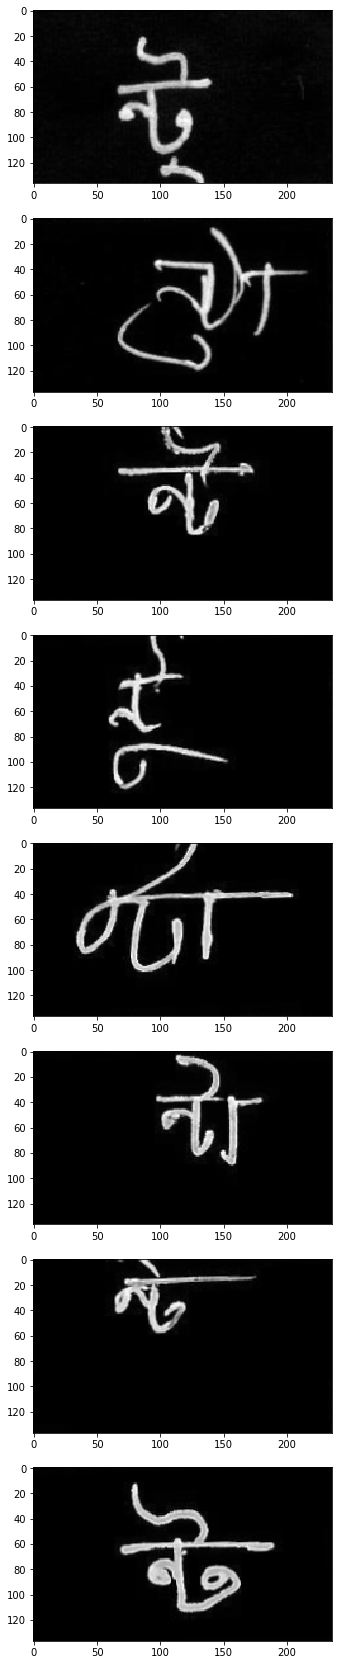

In [82]:
er1,nr1 = info_83[0],info_83[1]
er2,nr2 = info_37[0],info_37[1]
import matplotlib.pyplot as plt
fig, axs = plt.subplots( len(er1), figsize=(10, 30))
for i in range(len(er1)):
  img_er1 = cv2.imread(TRAIN_IMG_DIR+'/'+er1[i])
  #img2 = cv2.imread(TRAIN_IMG_DIR+'/'+er2[i])
  #img1_n = cv2.imread(TRAIN_IMG_DIR+'/'+nr1[i])
  #img_nr2 = cv2.imread(TRAIN_IMG_DIR+'/'+nr2[i])
  axs[i].imshow(img_er1)
  #axs[1][i].imshow(img_nr2)
  #axs[2][i].imshow(img2)
  #axs[3][i].imshow(img2_n)
    
plt.show()

In [0]:
def get_predicts(predicts, coefficients):
    return np.einsum("ij,j->ij", predicts, coefficients)

In [0]:
def get_labels_distribution(predicts, coefficients):
    n_preds = get_predicts(predicts, coefficients)
    labels = np.c_[np.argmax(n_preds[:,0:168],axis=1),np.argmax(n_preds[:,168:179], axis=1), np.argmax(n_preds[:,179:186],axis=1)]
    (unique,counter)=np.unique(labels, axis=0, return_counts=True)
    return unique,counter

In [0]:
def compute_score_with_coefficients(predicts, coefficients):
    unique,counter = get_labels_distribution(predicts, coefficients)
    counter = counter * 100 / len(predicts)
    max_scores = np.ones(len(counter)) * 100 / len(counter)

    for i in range(len(unique)):
      trip = unique[i]
      if np.array_equal(trip,[64,3,2]) or np.array_equal(trip,[64,7,2]) or np.array_equal(trip,[72,0,2]) or np.array_equal(trip,[167,7,0]): 
        max_scores[i]=max_scores[i]*2

    result= np.min(np.stack([counter, max_scores], axis=0), axis=0)

    return float(np.sum(result))

In [0]:
def find_best_coefficients(predicts, coefficients, alpha=0.001, iterations=100):
    best_coefficients = np.copy(coefficients)
    best_score = compute_score_with_coefficients(predicts, coefficients)

    for _ in tqdm(range(iterations)):
        unique,counter = get_labels_distribution(predicts, coefficients)
        label = np.argmax(counter)
        triplet = unique[label]
        root = triplet[0]
        vowel = triplet[1]
        cons = triplet[2]

        coefficients[root] -= alpha
        coefficients[168+vowel] -= alpha
        coefficients[179+cons] -= alpha

        score = compute_score_with_coefficients(predicts, coefficients)
        if score > best_score:
            best_score = score
            best_coefficients = np.copy(coefficients)

    return best_coefficients

In [0]:
g_preds=np.c_[np.array(root_predicts),np.array(vowel_predicts),np.array(cons_predicts)]
g_coeffs=np.ones((186))
unique,counter = get_labels_distribution(g_preds,g_coeffs)

In [0]:
for i in range(len(unique)):
  trip = unique[i]
  if np.array_equal(trip,[64,3,2]) or np.array_equal(trip,[64,7,2]) or np.array_equal(trip,[72,0,2]) or np.array_equal(trip,[167,7,0])  : print(i)


461
472
532
1345


In [0]:
from tqdm.auto import tqdm

g_preds=np.c_[np.array(root_predicts),np.array(vowel_predicts),np.array(cons_predicts)]
g_coeffs=np.ones((186))

last_score = compute_score_with_coefficients(g_preds, g_coeffs)
print("Start score", last_score)

alpha = 0.8
min_alpha = 0.01

while alpha >= min_alpha:
      g_coeffs = find_best_coefficients(g_preds, g_coeffs, iterations=300, alpha=alpha)
      new_score = compute_score_with_coefficients(g_preds, g_coeffs)

      if new_score <= last_score:
          alpha *= 0.5

      last_score = new_score
      print("Score: {}, alpha: {}".format(last_score, alpha))

predicts = get_predicts(g_preds, g_coeffs)

Start score 83.75550231714254



Score: 83.83657041910963, alpha: 0.8



Score: 83.83657041910963, alpha: 0.4



Score: 83.83657041910963, alpha: 0.2



Score: 83.83657041910963, alpha: 0.1



Score: 83.83657041910963, alpha: 0.05



Score: 83.84652859477185, alpha: 0.05



Score: 83.84652859477185, alpha: 0.025



Score: 83.84652859477185, alpha: 0.0125



Score: 83.84652859477185, alpha: 0.00625


In [0]:
new_r_preds = predicts[:,0:168]
new_v_preds = predicts[:,168:179]
new_c_preds = predicts[:,179:186]

In [0]:
compute_recall(valid_df,root_predicts,vowel_predicts,cons_predicts)

(0.9770964509712124, 0.994194193321082, 0.992392609022089)

In [0]:
compute_recall(valid_df,new_r_preds,new_v_preds,new_c_preds)

(0.9770759223452863, 0.9942664711343775, 0.9918287240335866)